# 1. Install dependencies 

In [1]:
!pip install torch torchvision torchaudio
!pip install tqdm

## 2. Data Pipeline

1. **Resize**: Fashion-MNIST images (28×28) → 224×224 for compatibility with ImageNet-pretrained networks.  
2. **Channel Conversion**: Duplicate the single grayscale channel into three channels (or learnable adapter).  
3. **Transforms**: Normalize with ImageNet mean/std and optionally apply data augmentation.
## 3. Model Definition

We use a pretrained CNN backbone  from `torchvision.models`.

### Steps:
- **Remove the original classification head**.
- **Freeze all backbone layers** to retain learned features.
- **Add a new fully-connected (FC) head** to output predictions for 10 Fashion-MNIST classes.

Freezing allows the model to retain previously learned generic visual features while we train a lightweight classifier on top.

## 4. Training the Classifier Head

We train only the new FC head using:

- **Loss Function**: CrossEntropyLoss
- **Optimizer**: Adam with LR = 1e-3
- **Epochs**: ~5–10 (for fast convergence)
- **Metrics**: Training and validation loss + accuracy

The backbone remains frozen. We monitor overfitting by comparing training and validation performance.

##  Fine-tuning the Backbone

Once the classifier head is trained, we **unfreeze selected deeper layers** (e.g., last few blocks of ResNet) and fine-tune them.



In [ ]:

# 2. Imports
# ----------
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm

# 3. Device setup
# ---------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 4. Hyperparameters
# ------------------
batch_size = 64
num_workers = 4
base_lr = 1e-3
ft_lr_backbone = 1e-5
ft_lr_head = 1e-4
weight_decay = 1e-4
num_epochs_head = 5
num_epochs_ft = 10
patience = 2  # for LR scheduler

# 5. Data transforms & loaders
# ----------------------------
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

def get_data_loaders(data_dir='./data'):
    train_tf = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize(*imagenet_stats),
    ])
    val_tf = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize(*imagenet_stats),
    ])

    train_ds = datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=train_tf)
    val_ds   = datasets.FashionMNIST(root=data_dir, train=False,download=True, transform=val_tf)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, val_loader

# 6. Model setup
# --------------
def build_model(num_classes=10, freeze_backbone=True):
    model = models.resnet50(pretrained=True)
    if freeze_backbone:
        for param in model.parameters(): param.requires_grad = False
    # replace head
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )
    return model.to(device)

# 7. Training & evaluation functions
# -----------------------------------
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in tqdm(loader, desc='Train', leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        _, preds_idx = preds.max(1)
        correct += (preds_idx == yb).sum().item()
        total += xb.size(0)
    return running_loss/total, correct/total


def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in tqdm(loader, desc='Val', leave=False):
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            running_loss += loss.item() * xb.size(0)
            _, preds_idx = preds.max(1)
            correct += (preds_idx == yb).sum().item()
            total += xb.size(0)
    return running_loss/total, correct/total

# 8. Main script
# --------------
def main():
    # data
    train_loader, val_loader = get_data_loaders()

    # 8a. Head-only training
    model = build_model(freeze_backbone=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=base_lr, weight_decay=weight_decay)

    print("\n==> Training head only")
    best_val_loss = float('inf')
    for epoch in range(1, num_epochs_head+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        print(f"Epoch {epoch}/{num_epochs_head}: tr_loss={tr_loss:.4f}, tr_acc={tr_acc:.4f}, "
              f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        best_val_loss = min(best_val_loss, val_loss)

    # 8b. Fine-tuning
    print("\n==> Fine-tuning deeper layers")
    # unfreeze last block
    for name, param in model.named_parameters():
        if 'layer4' in name:
            param.requires_grad = True

    # optimizer with param groups
    optimizer = optim.Adam([
        {'params': model.layer4.parameters(), 'lr': ft_lr_backbone},
        {'params': model.fc.parameters(),    'lr': ft_lr_head}
    ], weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience)

    for epoch in range(1, num_epochs_ft+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        scheduler.step(val_loss)
        lr_b = optimizer.param_groups[0]['lr']
        lr_h = optimizer.param_groups[1]['lr']
        print(f"FT Epoch {epoch}/{num_epochs_ft}: tr_acc={tr_acc:.4f}, val_acc={val_acc:.4f}, "
              f"lr_backbone={lr_b:.2e}, lr_head={lr_h:.2e}")

    # 9. Save best model
    os.makedirs('checkpoints', exist_ok=True)
    torch.save(model.state_dict(), 'checkpoints/fashion_mnist_resnet50_ft.pth')
    print("Model saved to checkpoints/fashion_mnist_resnet50_ft.pth")

if __name__ == '__main__':
    main()


Using device: cuda


100%|██████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:01<00:00, 15.5MB/s]
100%|███████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 228kB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:01<00:00, 4.18MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 16.9MB/s]
/home/sriya/gpu-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sriya/gpu-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/sriya/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 77.0MB/s]



==> Training head only


Epoch 1/5: tr_loss=0.7589, tr_acc=0.7307, val_loss=0.5124, val_acc=0.8102


Epoch 2/5: tr_loss=0.5942, tr_acc=0.7849, val_loss=0.4828, val_acc=0.8264


Epoch 3/5: tr_loss=0.5673, tr_acc=0.7945, val_loss=0.4455, val_acc=0.8408


Epoch 4/5: tr_loss=0.5495, tr_acc=0.8019, val_loss=0.4513, val_acc=0.8318


Epoch 5/5: tr_loss=0.5307, tr_acc=0.8065, val_loss=0.4336, val_acc=0.8426

==> Fine-tuning deeper layers


FT Epoch 1/10: tr_acc=0.8657, val_acc=0.8907, lr_backbone=1.00e-05, lr_head=1.00e-04


FT Epoch 2/10: tr_acc=0.9025, val_acc=0.9054, lr_backbone=1.00e-05, lr_head=1.00e-04


FT Epoch 3/10: tr_acc=0.9203, val_acc=0.9150, lr_backbone=1.00e-05, lr_head=1.00e-04


FT Epoch 4/10: tr_acc=0.9320, val_acc=0.9158, lr_backbone=1.00e-05, lr_head=1.00e-04


FT Epoch 5/10: tr_acc=0.9437, val_acc=0.9158, lr_backbone=1.00e-05, lr_head=1.00e-04


FT Epoch 6/10: tr_acc=0.9534, val_acc=0.9189, lr_backbone=5.00e-06, lr_head=5.00e-05


FT Epoch 7/10: tr_acc=0.9658, val_acc=0.9206, lr_backbone=5.00e-06, lr_head=5.00e-05


FT Epoch 8/10: tr_acc=0.9702, val_acc=0.9198, lr_backbone=5.00e-06, lr_head=5.00e-05


FT Epoch 9/10: tr_acc=0.9749, val_acc=0.9211, lr_backbone=2.50e-06, lr_head=2.50e-05


FT Epoch 10/10: tr_acc=0.9803, val_acc=0.9205, lr_backbone=2.50e-06, lr_head=2.50e-05
Model saved to checkpoints/fashion_mnist_resnet50_ft.pth


## Plotting Training Curves

Visualizations of loss and accuracy over epochs help diagnose:
- Convergence speed  
- Overfitting / underfitting  


/home/sriya/gpu-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sriya/gpu-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


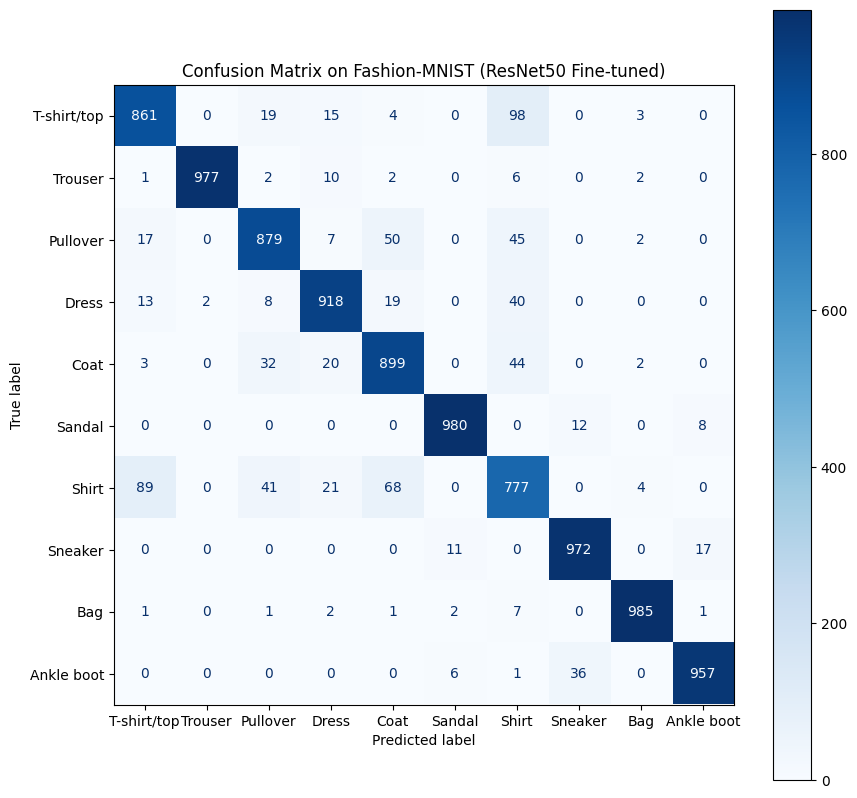

In [9]:
# visualization_block.py

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# === Load model and data (must match training setup) ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

val_tf = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.Normalize(*imagenet_stats),
])
val_ds = datasets.FashionMNIST(root='./data', train=False, transform=val_tf)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=False)

# Same model architecture as before
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
)
model.load_state_dict(torch.load('checkpoints/fashion_mnist_resnet50_ft.pth'))
model = model.to(device)
model.eval()

# === Evaluation and confusion matrix ===
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        preds = model(xb)
        preds = torch.argmax(preds, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_ds.classes)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Fashion-MNIST (ResNet50 Fine-tuned)")
plt.show()


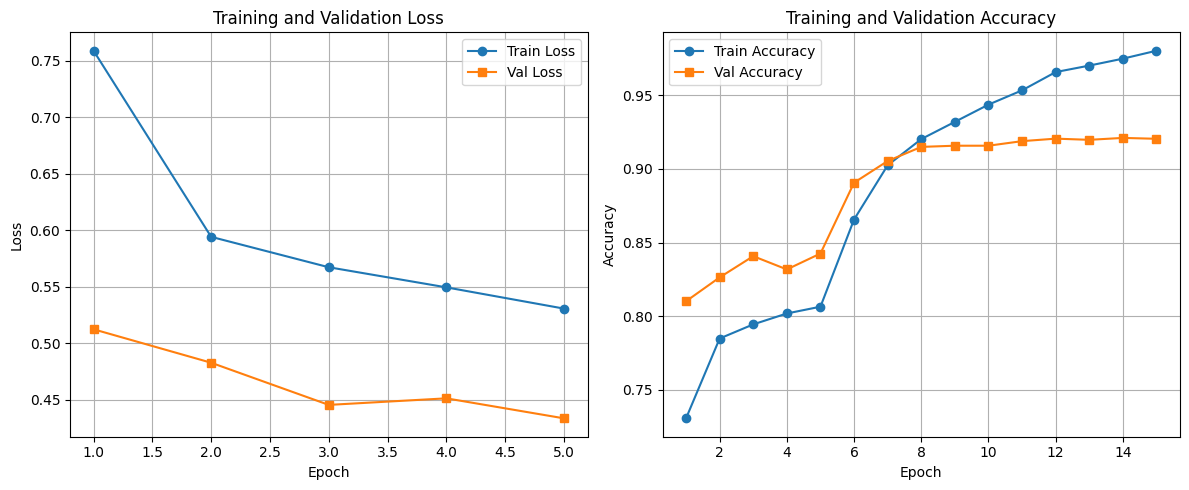

In [12]:
import matplotlib.pyplot as plt

# Assuming these are your collected metrics from training and fine-tuning phases:
train_losses = [0.7589, 0.5942, 0.5673, 0.5495, 0.5307]
val_losses = [0.5124, 0.4828, 0.4455, 0.4513, 0.4336]
train_accuracies = [0.7307, 0.7849, 0.7945, 0.8019, 0.8065,
                    0.8657, 0.9025, 0.9203, 0.9320, 0.9437,
                    0.9534, 0.9658, 0.9702, 0.9749, 0.9803]
val_accuracies = [0.8102, 0.8264, 0.8408, 0.8318, 0.8426,
                  0.8907, 0.9054, 0.9150, 0.9158, 0.9158,
                  0.9189, 0.9206, 0.9198, 0.9211, 0.9205]

# Epochs counts
epochs_head = len(train_losses)          # 5 epochs (head training)
epochs_ft = len(train_accuracies) - epochs_head  # 10 epochs (fine-tuning)

# Create combined x-axis for all epochs
epochs_all = list(range(1, epochs_head + epochs_ft + 1))

plt.figure(figsize=(12, 5))

# Plot Losses (only for head training, because no losses for fine-tuning given)
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_head + 1), train_losses, 'o-', label='Train Loss')
plt.plot(range(1, epochs_head + 1), val_losses, 's-', label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracies (both phases)
plt.subplot(1, 2, 2)
plt.plot(epochs_all, train_accuracies, 'o-', label='Train Accuracy')
plt.plot(epochs_all, val_accuracies, 's-', label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


🔹 Left: Loss Curves (5 Epochs)
Training loss decreases steadily → indicates effective learning.

Validation loss also decreases overall (minor uptick at Epoch 4) → good generalization.

Gap between training and validation losses remains moderate → no severe overfitting.

🔹 Right: Accuracy Curves (15 Epochs)
Validation accuracy improves rapidly until ~Epoch 7 and then plateaus around 92%.

Training accuracy continues rising past validation → indicates mild overfitting after Epoch 10.

This is normal and can be controlled with stronger regularization or early stopping.

